In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math
import scipy
from PIL import Image

from tensorflow.python.framework import ops
# from cnn_utils import *

In [110]:
import h5py

In [144]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [2]:
import tensorflow as tf

In [3]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [116]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = 10

In [6]:
print("X_train Shape =",X_train.shape)
print("y_train Shape =",y_train.shape)
print("X_test Shape = ",X_test.shape)
print("y_test Shape = ",y_test.shape)

X_train Shape = (50000, 32, 32, 3)
y_train Shape = (50000, 1)
X_test Shape =  (10000, 32, 32, 3)
y_test Shape =  (10000, 1)


[4]


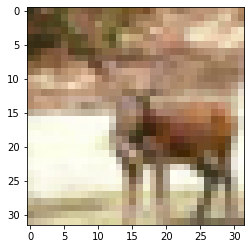

In [10]:
i=1001
plt.imshow(X_train[i])
print(y_train[i])
plt.ioff()

[7]


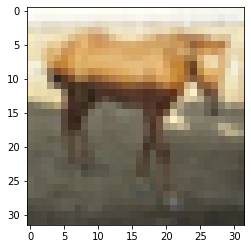

In [11]:
i=2000
plt.imshow(X_train[i])
print(y_train[i])
plt.ioff()

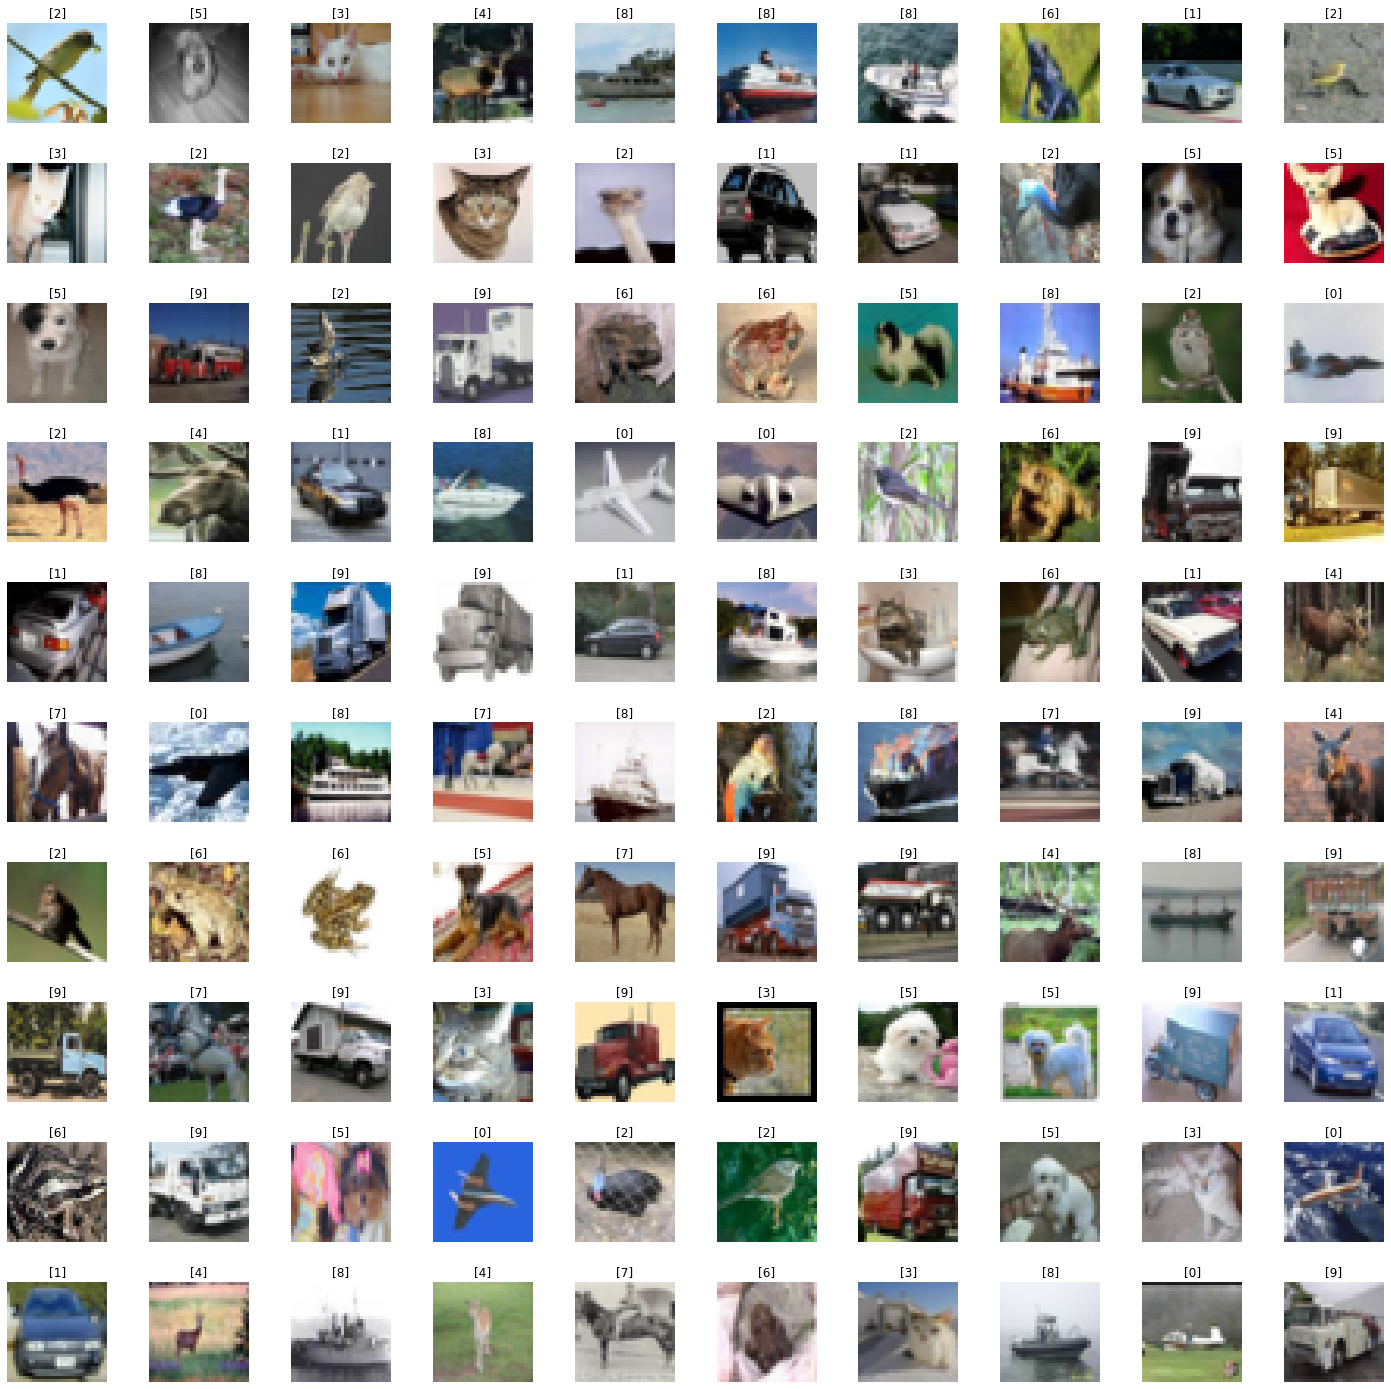

In [12]:
L_grid=10
W_grid=10
fig,axes = plt.subplots(L_grid,W_grid,figsize=(25,25))
axes=axes.ravel()
n_training=len(X_train)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) #Pick a random number 
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index]) #Prints labels on top of the picture
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [7]:
print("Total no. of classes in the data set: ",len(np.unique(y_train)))
np.unique(y_train)
      

Total no. of classes in the data set:  10


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Modeling using TensorFlow Without CNN

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector .

In [14]:
# Flatten the training and test images
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

In [15]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [16]:
# Convert training and test labels to one hot matrices
Y_train=one_hot_encode(y_train).T
Y_test=one_hot_encode(y_test).T
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Y_train shape: (10, 50000)
Y_test shape: (10, 10000)


In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3072, 50000)
X_test shape: (3072, 10000)


Note that 3072 comes from  32x32×3 . Each image is square, 32 by 32 pixels, and 3 is for the RGB colors. 

My goal is to build an algorithm capable of recognizing a sign with high accuracy. To do so, I am going to build a tensorflow model 

The model is LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX. The SIGMOID output layer has been converted to a SOFTMAX. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes.

### 2.1 - Create placeholders

First task is to create placeholders for X and Y. This will allow me to later pass my training data in when you run your session.



In [18]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 32 * 32 * 3 = 3072)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

   
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")

    
    return X, Y

In [19]:
X, Y = create_placeholders(3072, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(3072, ?), dtype=float32)
Y = Tensor("Y:0", shape=(10, ?), dtype=float32)


### 2.2 - Initializing the parameters

Second task is to initialize the parameters in tensorflow.

Implementing the function below to initialize the parameters in tensorflow. I am going to use Xavier Initialization for weights and Zero Initialization for biases. 


Please use seed = 1 to make sure your results match ours.

In [20]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 3072]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [10, 12]
                        b3 : [10, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   
        
    
    W1 = tf.get_variable("W1", [25, 3072], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [26]:
tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 3072) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


As expected, the parameters haven't been evaluated yet.

### 2.3 - Forward propagation in tensorflow

I will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions you will be using are:

tf.add(...,...) to do an addition
tf.matmul(...,...) to do a matrix multiplication
tf.nn.relu(...) to apply the ReLU activation

Implement the forward pass of the neural network.It is important to note that the forward propagation stops at z3. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need a3!

In [27]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                         # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3                                                      
    
    
    
    return Z3

In [34]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(3072,10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(10, ?), dtype=float32)


In [29]:
# !pip install tensorflow==1.14

In [3]:
# tf.__version__

'1.14.0'

You may have noticed that the forward propagation doesn't output any cache. You will understand why below, when we get to brackpropagation

### 2.4 Compute cost
As seen before, it is very easy to compute the cost using:

tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))

Question: Implementing the cost function below.

It is important to know that the "logits" and "labels" inputs of tf.nn.softmax_cross_entropy_with_logits are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
Besides, tf.reduce_mean basically does the summation over the examples.

In [36]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =logits, labels=labels))
   
    
    return cost

In [37]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(3072,10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


### 2.5 - Backward propagation & parameter updates

This is where I become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After you compute the cost function. You will create an "optimizer" object. You have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
To make the optimization you would do:

_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
This computes the backpropagation by passing through the tensorflow graph in the reverse order. From cost to inputs.

Note When coding, we often use _ as a "throwaway" variable to store values that we won't need to use later. Here, _ takes on the evaluated value of optimizer, which we don't need (and c takes the value of the cost variable).



### 2.6 - Building the model
Now, you will bring it all together!

Exercise: Implement the model. You will be calling the functions you had previously implemented.

Implement random_mini_batches that selects the indexes for the  1𝑠𝑡  and  2𝑛𝑑  mini-batches:

first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
...
Note that the last mini-batch might end up smaller than mini_batch_size=64. Let  ⌊𝑠⌋  represents  𝑠  rounded down to the nearest integer (this is math.floor(s) in Python). If the total number of examples is not a multiple of mini_batch_size=64 then there will be  ⌊𝑚𝑚𝑖𝑛𝑖_𝑏𝑎𝑡𝑐ℎ_𝑠𝑖𝑧𝑒⌋  mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be ( 𝑚−𝑚𝑖𝑛𝑖_𝑏𝑎𝑡𝑐ℎ_𝑠𝑖𝑧𝑒×⌊𝑚𝑚𝑖𝑛𝑖_𝑏𝑎𝑡𝑐ℎ_𝑠𝑖𝑧𝑒⌋ ).

In [38]:
from tensorflow.python.framework import ops

In [55]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((10,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [56]:
# X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_train, Y_train,64)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (3072, 64)
shape of the 2nd mini_batch_X: (3072, 64)
shape of the 3rd mini_batch_X: (3072, 64)
shape of the 1st mini_batch_Y: (10, 64)
shape of the 2nd mini_batch_Y: (10, 64)
shape of the 3rd mini_batch_Y: (10, 64)
mini batch sanity check: [0.32156863 0.62745098 0.77647059]


In [57]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
   
    X, Y = create_placeholders(n_x,n_y)
   

    # Initialize parameters
  
    parameters = initialize_parameters()
    
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
   
    cost = compute_cost(Z3, Y)
   
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
   
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
               
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 27.100349
Cost after epoch 100: 16.726386
Cost after epoch 200: 15.630773
Cost after epoch 300: 14.989655
Cost after epoch 400: 14.550148
Cost after epoch 500: 14.109712
Cost after epoch 600: 13.861722
Cost after epoch 700: 13.530140
Cost after epoch 800: 13.365269
Cost after epoch 900: 13.165595
Cost after epoch 1000: 12.915881
Cost after epoch 1100: 12.762127
Cost after epoch 1200: 12.641107
Cost after epoch 1300: 12.493883
Cost after epoch 1400: 12.401072


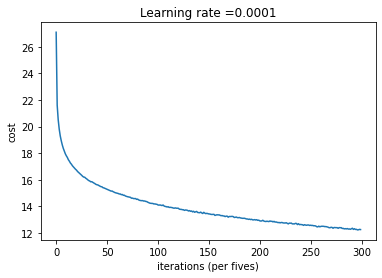

Parameters have been trained!
Train Accuracy: 0.62554
Test Accuracy: 0.4356


In [58]:
parameters = model(X_train, Y_train, X_test, Y_test)

Think about the session as a block of code to train the model. Each time you run the session on a minibatch, it trains the parameters. In total you have run the session a large number of times (1500 epochs) until you obtained well trained parameters.

### 2.7 - Test with your own image (optional / ungraded exercise)

In [134]:

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    Z3 = forward_propagation(X, parameters)
    def maxi(x):
        return (np.where(max(x)))
    large_index=maxi(Z3)
#     A3=np.exp(Z3)/np.sum(np.exp(Z3))

    predictions = large_index
    ### END CODE HERE ###
    
    return predictions

In [124]:
d=np.random.randint(0,8,size=(10,))
print(d)
print(np.where(d==6))

[0 3 0 5 6 7 5 0 6 0]
(array([4, 8], dtype=int64),)


In [141]:
# import scipy
# from PIL import Image
# from scipy import ndimage
# import scipy.misc
# import imageio
# from skimage.transform import resize
# # from scipy import imageio
# # import Image as Imge

# ## START CODE HERE ## (PUT YOUR IMAGE NAME) 
# fname = "test_image.jpg"
# ## END CODE HERE ##

# # We preprocess your image to fit your algorithm.
# # fname = "images/" + my_image
# image = np.array(imageio.imread(fname))
# image = image/255.
# # my_image=numpy.array(Image.fromarray().resize())
# my_image =resize(image, (32,32)).reshape(32*32*3,1)
# my_image_prediction = predict(my_image, parameters)

# plt.imshow(image)
# print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

In [129]:
# !pip install scikit-image

In [130]:
# !pip install Pillow

In [131]:
# !pip install imageio

### With CNN

##### if you are modeling with CNN no need to flatten the image by reshaping later we can flatten the image in the full connected layer

[1]


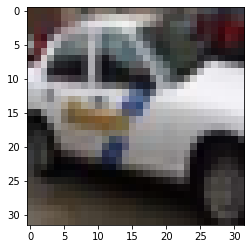

In [8]:
i=2005 #change the i values to desire value
plt.imshow(X_train[i])
print(y_train[i])
plt.ioff()

In [9]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y.astype(int)


# y=convert_to_one_hot(y_train,10)
# print(y.shape)

In [10]:
X_train = X_train/255.
X_test = X_test/255.
Y_train = convert_to_one_hot(y_train, 10).T
Y_test = convert_to_one_hot(y_test, 10).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


### 1.1 - Create placeholders
TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

Exercise: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension [None, n_H0, n_W0, n_C0] and Y should be of dimension [None, n_y]. Hint: search for the tf.placeholder documentation".

In [11]:

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    ### END CODE HERE ###
    
    return X, Y

### 1.2 - Initialize parameters
You will initialize weights/filters  W1W1  and  W2W2  using tf.contrib.layers.xavier_initializer(seed = 0). You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. 

Exercise: Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter  WW  of shape [1,2,3,4] in Tensorflow, use:

W = tf.get_variable("W", [1,2,3,4], initializer = ...)
tf.get_variable()
Search for the tf.get_variable documentation. Notice that the documentation says:

Gets an existing variable with these parameters or create a new one.
So we can use this function to create a tensorflow variable with the specified name, but if the variables already exist, it will get the existing variable with that same name.

In [13]:


def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 1.3 - Forward propagation
In TensorFlow, there are built-in functions that implement the convolution steps for you.

tf.nn.conv2d(X,W, strides = [1,s,s,1], padding = 'SAME'): given an input  XX  and a group of filters  WW , this function convolves  WW 's filters on X. The third parameter ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Normally, you'll choose a stride of 1 for the number of examples (the first value) and for the channels (the fourth value), which is why we wrote the value as [1,s,s,1]. You can read the full documentation on conv2d.

tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'): given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. For max pooling, we usually operate on a single example at a time and a single channel at a time. So the first and fourth value in [1,f,f,1] are both 1. You can read the full documentation on max_pool.

tf.nn.relu(Z): computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on relu.

tf.contrib.layers.flatten(P): given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.

If a tensor P has the shape (m,h,w,c), where m is the number of examples (the batch size), it returns a flattened tensor with shape (batch_size, k), where  k=h×w×ck=h×w×c . "k" equals the product of all the dimension sizes other than the first dimension.
For example, given a tensor with dimensions [100,2,3,4], it flattens the tensor to be of shape [100, 24], where 24 = 2 3 4. You can read the full documentation on flatten.
tf.contrib.layers.fully_connected(F, num_outputs): given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on full_connected.

In the last function above (tf.contrib.layers.fully_connected), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Window, kernel, filter
The words "window", "kernel", and "filter" are used to refer to the same thing. This is why the parameter ksize refers to "kernel size", and we use (f,f) to refer to the filter size. Both "kernel" and "filter" refer to the "window."

Implement the forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED. You should use the functions above.

In detail, we will use the following parameters for all the steps:

Conv2D: stride 1, padding is "SAME"
ReLU
Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
Conv2D: stride 1, padding is "SAME"
ReLU
Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
Flatten the previous output.
FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [14]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F, 10, activation_fn=None)
    ### END CODE HERE ###

    return Z3

### 1.4 - Compute cost
Implement the compute cost function below. Remember that the cost function helps the neural network see how much the model's predictions differ from the correct labels. By adjusting the weights of the network to reduce the cost, the neural network can improve its predictions.

You might find these two functions helpful:

tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y): computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation softmax_cross_entropy_with_logits.
tf.reduce_mean: computes the mean of elements across dimensions of a tensor. Use this to calculate the sum of the losses over all the examples to get the overall cost. You can check the full documentation reduce_mean.
Details on softmax_cross_entropy_with_logits (optional reading)
Softmax is used to format outputs so that they can be used for classification. It assigns a value between 0 and 1 for each category, where the sum of all prediction values (across all possible categories) equals 1.
Cross Entropy is compares the model's predicted classifications with the actual labels and results in a numerical value representing the "loss" of the model's predictions.
"Logits" are the result of multiplying the weights and adding the biases. Logits are passed through an activation function (such as a relu), and the result is called the "activation."
The function is named softmax_cross_entropy_with_logits takes logits as input (and not activations); then uses the model to predict using softmax, and then compares the predictions with the true labels using cross entropy. These are done with a single function to optimize the calculations.

In [15]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

### 1.5 Model
Finally you will merge the helper functions you implemented above to build a model. You will train it on the SIGNS dataset.

Exercise: Complete the function below.

The model below should:

create placeholders
initialize parameters
forward propagate
compute the cost
create an optimizer
Finally you will create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. Hint for initializing the variables

Adam Optimizer
You can use tf.train.AdamOptimizer(learning_rate = ...) to create the optimizer. The optimizer has a minimize(loss=...) function that you'll call to set the cost function that the optimizer will minimize.

For details, check out the documentation for Adam Optimizer

Evaluating the optimizer and cost
Within a loop, for each mini-batch, you'll use the tf.Session object (named sess) to feed a mini-batch of inputs and labels into the neural network and evaluate the tensors for the optimizer as well as the cost. Remember that we built a graph data structure and need to feed it inputs and labels and use sess.run() in order to get values for the optimizer and cost.

You'll use this kind of syntax:

output_for_var1, output_for_var2 = sess.run(
                                                fetches=[var1, var2],
                                                feed_dict={var_inputs: the_batch_of_inputs,
                                                           var_labels: the_batch_of_labels}
                                                )
Notice that sess.run takes its first argument fetches as a list of objects that you want it to evaluate (in this case, we want to evaluate the optimizer and the cost).
It also takes a dictionary for the feed_dict parameter.
The keys are the tf.placeholder variables that we created in the create_placeholders function above.
The values are the variables holding the actual numpy arrays for each mini-batch.
The sess.run outputs a tuple of the evaluated tensors, in the same order as the list given to fetches.

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation].reshape((m,10))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [206]:
# X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_train, Y_train,64)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (64, 32, 32, 3)
shape of the 2nd mini_batch_X: (64, 32, 32, 3)
shape of the 3rd mini_batch_X: (64, 32, 32, 3)
shape of the 1st mini_batch_Y: (64, 10)
shape of the 2nd mini_batch_Y: (64, 10)
shape of the 3rd mini_batch_Y: (64, 10)
mini batch sanity check: [[[0.32156863 0.61568627 0.76078431]
  [0.32941176 0.61176471 0.74901961]
  [0.33333333 0.60392157 0.7372549 ]
  [0.33333333 0.60392157 0.72941176]
  [0.34117647 0.60784314 0.7372549 ]
  [0.36078431 0.61176471 0.74509804]
  [0.38039216 0.62352941 0.76078431]
  [0.39607843 0.63921569 0.78039216]
  [0.4        0.63921569 0.78039216]
  [0.37254902 0.62352941 0.76078431]
  [0.34901961 0.61960784 0.75294118]
  [0.35686275 0.61568627 0.75294118]
  [0.34509804 0.62745098 0.75686275]
  [0.34117647 0.62745098 0.75686275]
  [0.34117647 0.62745098 0.75686275]
  [0.3372549  0.61960784 0.75294118]
  [0.33333333 0.61960784 0.75686275]
  [0.3254902  0.60784314 0.75294118]
  [0.31764706 0.6        0.74509804]
  [0.313725

In [207]:
Y_train.shape

(50000, 10)

In [17]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.849432
Cost after epoch 5: 1.597343
Cost after epoch 10: 1.554906
Cost after epoch 15: 1.528589
Cost after epoch 20: 1.513798
Cost after epoch 25: 1.507548
Cost after epoch 30: 1.498238
Cost after epoch 35: 1.486964
Cost after epoch 40: 1.482847
Cost after epoch 45: 1.476184
Cost after epoch 50: 1.466758
Cost after epoch 55: 1.463705
Cost after epoch 60: 1.463

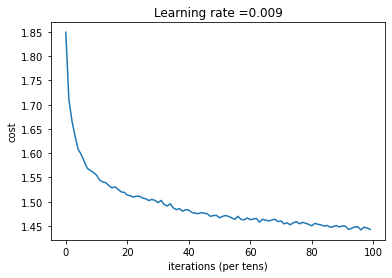

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.47548
Test Accuracy: 0.4701


In [18]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

### USING KERAS+CNN (Using Batch Normalization)

In [155]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [43]:
# def convert_to_one_hot(Y, C):
#     Y = np.eye(C)[Y.reshape(-1)].T
#     print(Y)
#     return Y.astype(int)

In [42]:
# y_train1=y_train.copy()
# y_train2=y_train.copy()

In [41]:
# convert_to_one_hot(y_train1,10)

In [40]:
# !pip install sklearn

In [117]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y_train = lb.fit_transform(y_train)
Y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [118]:
Y_test=lb.fit_transform(y_test)
Y_test # While result LabelBinarizer will be in (m,Classes)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [54]:
# Y_train.shape
# Y_test.shape

(10000, 10)

In [119]:
#Normalizing the data first
X_train=X_train/255
X_test=X_test/255

#Reshaping is not necessary if you use LabelBinarizer
Y_train=Y_train
Y_test=Y_test

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


#### Built a funciton that describes your model

In [66]:
# def kerasModel(input_shape):
#     X_input = Input(input_shape)

#     # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((3, 3))(X_input)

#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
#     X = BatchNormalization(axis=3, name='bn0')(X)
#     X = Activation('relu')(X)

#     # MAXPOOL
#     X = MaxPooling2D((2, 2), name='max_pool')(X)

#     # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
#     X = Flatten()(X)
#     X = Dense(10, activation='softmax', name='fc')(X)

#     # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
#     model = Model(inputs=X_input, outputs=X, name='kerasModel')

#     return model

In [123]:
from keras.models import Sequential 
Input_shape = X_train.shape[1:]
kerasmodel=Sequential()
kerasmodel.add(ZeroPadding2D((3,3)))

kerasmodel.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),input_shape=Input_shape))
kerasmodel.add(BatchNormalization(axis=3,name='bn0'))
kerasmodel.add(Activation('relu'))
kerasmodel.add(MaxPooling2D(2,2))

kerasmodel.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1)))
kerasmodel.add(BatchNormalization(axis=3,name='bn1'))
kerasmodel.add(Activation('relu'))
kerasmodel.add(MaxPooling2D(2,2))

kerasmodel.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1)))
kerasmodel.add(BatchNormalization(axis=3,name='bn2'))
kerasmodel.add(Activation('relu'))
kerasmodel.add(MaxPooling2D(2,2))


kerasmodel.add(Flatten())

kerasmodel.add(Dense(units=128,activation='relu'))
kerasmodel.add(Dense(units=64,activation='relu'))
kerasmodel.add(Dense(units=10,activation='softmax'))


1. Create a model

In [67]:
# kerasmodel=kerasModel(X_train.shape[1:])

2. Compile the model

In [124]:
kerasmodel.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

3.Train the model

In [125]:
kerasmodel.fit(X_train,Y_train,epochs=40,batch_size=50)

Epoch 1/40
50000/50000 [==============================] - 395s 8ms/step - loss: 1.2737 - accuracy: 0.5415
Epoch 2/40
50000/50000 [==============================] - 389s 8ms/step - loss: 0.9081 - accuracy: 0.6789
Epoch 3/40
50000/50000 [==============================] - 387s 8ms/step - loss: 0.7685 - accuracy: 0.7297
Epoch 4/40
50000/50000 [==============================] - 387s 8ms/step - loss: 0.6800 - accuracy: 0.7606
Epoch 5/40
50000/50000 [==============================] - 395s 8ms/step - loss: 0.6062 - accuracy: 0.7855
Epoch 6/40
50000/50000 [==============================] - 431s 9ms/step - loss: 0.5487 - accuracy: 0.8065
Epoch 7/40
50000/50000 [==============================] - 366s 7ms/step - loss: 0.4987 - accuracy: 0.8246
Epoch 8/40
50000/50000 [==============================] - 379s 8ms/step - loss: 0.4545 - accuracy: 0.8398
Epoch 9/40
50000/50000 [==============================] - 400s 8ms/step - loss: 0.4117 - accuracy: 0.8529
Epoch 10/40
50000/50000 [=====================

KeyboardInterrupt: 

4. Evaluate the Model

In [127]:
preds = kerasmodel.evaluate(X_test, Y_test, batch_size=40, verbose=1, sample_weight=None)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 25s 2ms/step

Loss = 1.2955219888687133
Test Accuracy = 0.7249000072479248


In [87]:
# !pip install keras.utils

In [128]:
predicted_classes=kerasmodel.predict_classes(X_test, batch_size=21)
predicted_classes

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [131]:
y_test=Y_test.argmax(1)
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [88]:
# classes = model2.predict_classes(X_test, batch_size=1)
# print(classes)

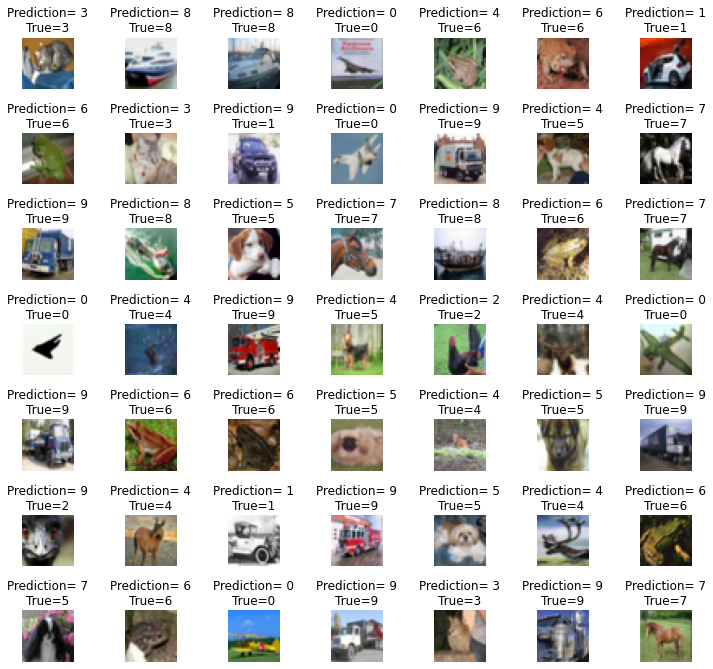

In [132]:
L=7  
W=7
fig,axes=plt.subplots(L,W,figsize=(12,12))
axes=axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction= {}\nTrue={}'.format(predicted_classes[i],y_test[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#### Test with your own image

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


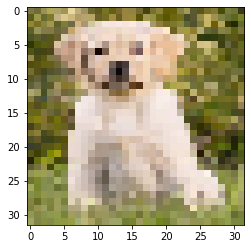

In [140]:
img_path = 'test_image.jpg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(32, 32))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(kerasmodel.predict(x))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


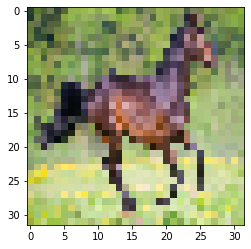

In [134]:
img_path = 'test_image1.png'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(32, 32))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(kerasmodel.predict(x))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


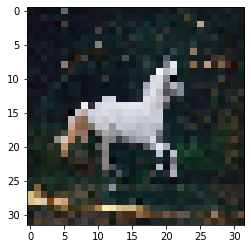

In [141]:
img_path = 'test_image2.jpeg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(32, 32))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(kerasmodel.predict(x))

In [91]:
kerasmodel.summary()

Model: "kerasModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 38, 38, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 32, 32, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0

In [8]:
# # !pip install GraphViz
# # pip install pydotplus
# !pip install StringIO

In [7]:
# !pip install pydotplus

In [5]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
# from IPython.display import Image
# import pydotplus

In [6]:
# !pip install sklearn

In [4]:
# plot_model(kerasmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [2]:
# # feature_cols=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
# dot_data=StringIO()
# export_graphviz(classifier,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names=X.columns,
#                 class_names=['0','1'])
# graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('diabetes.png')
# Image(graph.create_png())

In [1]:
# import os
# import pydot_ng as pydot
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot_model(kerasmodel, to_file='kerasmodel.png')
# SVG(model_to_dot(kerasmodel).create(prog='dot.exe', format='svg'))
# # os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [3]:
# # !pip install pydot
# # !pip install pydotplus
# # apt-get install graphviz
# !pip install pydot_ng